In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
def getPortsData(df: pd.DataFrame, originPort: str, destinationPortCity: str,
                destinationPortCountry: str) -> pd.Series:
   # streamline data so it has route and date column
   df['Route'] = df['AustralianPort'] + ' <-> ' + df['ForeignPort'] + ' (' + df['Country'] + ')'
   df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month_num'].astype(str) + '-01')


   # build route string using the provided destination country
   routeStr = f"{originPort} <-> {destinationPortCity} ({destinationPortCountry})"


   routeDF = df[df['Route'] == routeStr].copy()
   timeSeries = routeDF.set_index('Date')['Passengers_Total'].sort_index()


   # Add route info as name attribute
   timeSeries.name = routeStr


   return timeSeries



Monthly standardized accuracy for 1988-01 to 1988-12:
Month 01: Accuracy ≈ 0.9935
Month 02: Accuracy ≈ 0.9012
Month 03: Accuracy ≈ 0.9752
Month 04: Accuracy ≈ 0.9200
Month 05: Accuracy ≈ 0.9625
Month 06: Accuracy ≈ 0.9923
Month 07: Accuracy ≈ 0.9641
Month 08: Accuracy ≈ 0.8988
Month 09: Accuracy ≈ 0.9507
Month 10: Accuracy ≈ 0.8767
Month 11: Accuracy ≈ 0.8053
Month 12: Accuracy ≈ 0.8905


/Users/arjunsikka/PycharmProjects/dataGenerate/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/arjunsikka/PycharmProjects/dataGenerate/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/arjunsikka/PycharmProjects/dataGenerate/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


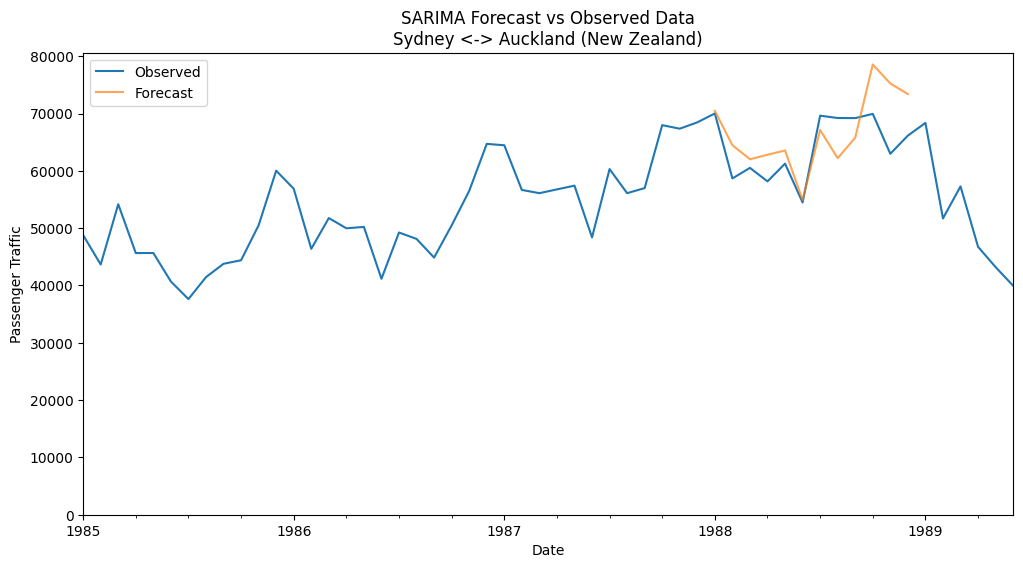

In [8]:
def runModel(timeSeries: pd.Series, trainEnd: str, testStart: str, testEnd: str,
            order: tuple = (1,1,1), seasonalOrder: tuple = (1,1,1,12)) -> dict:
   # order: (p=1, d=1, q=1):
   #   p=1: use 1 previous month to predict current
   #   d=1: use first differencing to remove trend
   #   q=1: use 1 previous error term for smoothing


   # seasonalOrder: (P=1, D=1, Q=1, s=12) where:
   #   P=1: use same month from 1 previous year
   #   D=1: use seasonal differencing to remove yearly patterns
   #   Q=1: use 1 previous seasonal error term
   #   s=12: 12-month seasonal cycle
   # https://www.geeksforgeeks.org/machine-learning/sarima-seasonal-autoregressive-integrated-moving-average/#


   # train on all data up to trainEnd
   train = timeSeries[:trainEnd]


   # see if test data exists in our dataset
   try:
       test = timeSeries[testStart:testEnd]
       hasTestData = len(test) > 0
   except:
       hasTestData = False
       test = None


   # create and train the SARIMA model using specified parameters
   model = sm.tsa.statespace.SARIMAX(
       train,
       order=order,
       seasonal_order=seasonalOrder,
       enforce_stationarity=False, # allow data to have overall trend like growth
       enforce_invertibility=True  # setting True puts more weight in recent events like strike
   )
   results = model.fit(disp=False)


   # predict the test period
   predictions = results.get_prediction(
       start=pd.to_datetime(testStart + '-01'),
       end=pd.to_datetime(testEnd + '-01'),
       dynamic=False
   )
   predMean = predictions.predicted_mean


   # Only calculate accuracy if we have actual test data
   if hasTestData and test is not None:
       monthlyAccuracy = {}
       startMonth = int(testStart.split('-')[1])


       for i in range(len(test)):
           month = startMonth + i
           if i < len(predMean):
               actual = test.iloc[i]
               pred = predMean.iloc[i]
               monthlyAccuracy[month] = 1 - abs(actual - pred) / actual


       print(f"Monthly standardized accuracy for {testStart} to {testEnd}:")
       for month, acc in monthlyAccuracy.items():
           print(f"Month {month:02d}: Accuracy ≈ {acc:.4f}")
   else:
       # only show forecast values when no test data exists
       print(f"Forecasted passenger traffic for {testStart} to {testEnd}:")
       dates = pd.date_range(start=testStart, periods=len(predMean), freq="MS")  # MS = month start


       for date, pred in zip(dates, predMean):
           print(f"{date.year}-{date.month:02d}: {pred:,.0f} passengers")


   # plot results
   ax = timeSeries.plot(label='Observed', figsize=(12, 6))
   predMean.plot(ax=ax, label='Forecast', alpha=0.7)
   ax.set_xlabel('Date')
   ax.set_ylabel('Passenger Traffic')
   plt.title(f'SARIMA Forecast vs Observed Data\n{timeSeries.name}')
   plt.legend()
   plt.ylim(bottom=0)
   plt.show()


   # Return appropriate data
   return monthlyAccuracy if hasTestData else predMean




# use this time frame if you want to actually predict attendance in the future as specified in the instructions (6-12 months in advance).
# you can change testEnd to increase or decrease this range.
#trainEnd, testStart, testEnd = '1989-07', '1989-07', '1990-12'


# this is for training the model on the given data but also testing it on the same data but in a later year so we can
# validate its accuracy. right now it gets trained up until the beginning of 1988 and gets tested on the entirety of 1988
trainEnd, testStart, testEnd = '1987-12','1988-01', '1988-12'


monthlyAcc = runModel(ts, trainEnd, testStart, testEnd)


In [5]:
df = pd.read_csv('AeroConnectData.csv')


ts = getPortsData(df, 'Sydney', 'Auckland', 'New Zealand')


monthlyAcc = runModel(ts)



TypeError: runModel() missing 3 required positional arguments: 'trainEnd', 'testStart', and 'testEnd'